<a href="https://colab.research.google.com/github/kalmuroth/python-exo/blob/master/Analyse_Donn%C3%A9e_WOW_2008_LB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nous allons étudier des données qui correspondent aux connexion de personnages-joueurs dans le jeu-vidéo World Of Warcraft sur un serveur en 2008.

Chaque row dans le fichier .csv correspond à une connexion quotidienne d'un joueur.

Sur un axe de 1 ans (année 2008), nous avons un total de 10 millions de connexion.

Je vais utiliser les librairies Python Pandas/Numpy/Seaborn pour étudier et analyser ces données visuellement pour démontrer l'impact de l'extension sur les joueurs.

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc
from datetime import timedelta
import random
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls


Mounted at /content/drive
drive  sample_data


# Préparer les données <a id="1"></a>

### Fichier en entrée <a id="2"></a>

In [66]:
print('%-33s %d' % ('Nombre de Fichier .csv :', len(os.listdir('./drive/MyDrive/input'))))
for i in range(34):
    print('-',end='')
print('-')
for file in os.listdir("./drive/MyDrive/input"):
    unit = 'MB'
    size = os.stat('./drive/MyDrive/input/' + file).st_size
    if round(size / 2**20, 2) < 0.5:
        size = round(size / 2**10, 2)
        unit = 'KB'
    else:
        size = round(size / 2**20, 2)
    print('%-25s %6.2f %2s' % (file, size, unit))

Nombre de Fichier .csv :          1
-----------------------------------
wowah_data.csv            623.93 MB


# Présentation des données <a id="1"></a>

### Les Joueurs <a id="2"></a>

On va commencer par quelque chose de simple, regarder un peu ce que représente un row dans nos données (+ on parse un peu le dataframe).

In [74]:
wowah_data = pd.read_csv('./drive/MyDrive/input/wowah_data.csv', sep = ',', skipinitialspace=True);
wowah_data['timestamp'] = pd.to_datetime(wowah_data['timestamp'])
wowah_data['dates'] = wowah_data['timestamp'].dt.date
wowah_data.loc[wowah_data['timestamp'] >= '2008-11-18','extention'] = 'WOTLK'
wowah_data.loc[wowah_data['timestamp'] < '2008-11-18', 'extention'] = 'BC'

dict_color = {'Death Knight': '#C41F3B',
                'Shaman': '#0070DE',
                'Druid': '#FF7D0A',
                'Rogue': '#FFF569',
                'Priest': '#FFFFFF',
                'Paladin': '#F58CBA',
                'Warrior': '#C79C6E',
                'Warlock': '#8787ED',
                'Mage': '#40C7EB',
                'Hunter': '#A9D271'}

wowah_data['Class_color']  = wowah_data.charclass.map(dict_color)

wowah_data['Date'] =  pd.to_datetime(wowah_data['timestamp'], format='%Y-%m-%d')
wowah_data["Day_of_Week"] = wowah_data.Date.dt.weekday
wowah_data["First_day_of_the_week"] = wowah_data.Date - wowah_data.Day_of_Week * timedelta(days=1)
wowah_data.drop(['Day_of_Week', 'Date'], axis = 1, inplace = True)
wowah_data["First_day_of_the_week"] = wowah_data["First_day_of_the_week"].dt.date

col = {}
for i in wowah_data.zone.unique() :
    color = "%06x" % random.randint(0, 0xFFFFFF)
    col[i] = '#' + color 
wowah_data['color_zone'] = wowah_data['zone'].map(col)

wowah_data.head()

,char,level,race,charclass,zone,guild,timestamp,dates,extention,Class_color,First_day_of_the_week,color_zone
0,59425,1,Orc,Rogue,Orgrimmar,165,2008-01-01 00:02:04,2008-01-01,BC,#FFF569,2007-12-31,#4ca118
1,65494,9,Orc,Hunter,Durotar,-1,2008-01-01 00:02:04,2008-01-01,BC,#A9D271,2007-12-31,#e30bbb
2,65325,14,Orc,Warrior,Ghostlands,-1,2008-01-01 00:02:04,2008-01-01,BC,#C79C6E,2007-12-31,#4f85c7
3,65490,18,Orc,Hunter,Ghostlands,-1,2008-01-01 00:02:04,2008-01-01,BC,#A9D271,2007-12-31,#4f85c7
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,2008-01-01 00:02:09,2008-01-01,BC,#A9D271,2007-12-31,#d3e035


Chaque ligne représente la connexion d'un joueur sur son personnage. 
Seulement la première connexion quotidienne a été enregistrer.

Timestamp représente le moment où le joueur s'est connecté la première fois dans la journée.

In [68]:
wowah_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 8 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   char       int64 
 1   level      int64 
 2   race       object
 3   charclass  object
 4   zone       object
 5   guild      int64 
 6   timestamp  object
 7   month      object
dtypes: int64(3), object(5)
memory usage: 660.8+ MB


Si on compte le total d'utilisateur qui s'est connecté par mois, nous pouvons déterminer le total de connexion mensuelle.

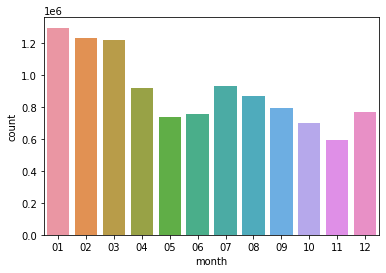

In [69]:
sns.countplot(x="month",data=wowah_data)

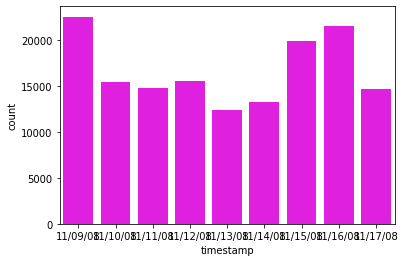

In [70]:
sns.countplot(x=wowah_data.timestamp[(wowah_data.timestamp > "11/08/08") & (wowah_data.timestamp < "11/18/08")], color="magenta")

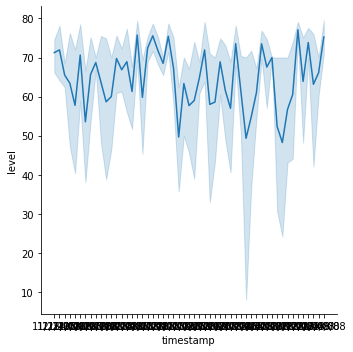

In [71]:
sns.relplot(x="timestamp", y="level", data=wowah_data[(wowah_data.timestamp > "11/01/08") & (wowah_data.timestamp < "12/25/08")].sample(n=500), kind="line",  sort=True)